#### Setup

In [36]:
# Notebook für Waldbrand-Modellierung
# Importiere die notwendigen Bibliotheken
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Bibliotheken für Dateioperationen
import os
import sys
import logging
import random
from pathlib import Path

# Projekt-Root dynamisch ermitteln
PROJECT_ROOT = Path.cwd().parent  # Falls Notebook in einem Unterverzeichnis liegt
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))  # Projekt-Root zu sys.path hinzufügen

# Wichtige Verzeichnisse definieren
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed" / "Wildfire"
TEST_DATA_DIR = PROJECT_ROOT / "data" / "processed" / "Wildfire_test"
SAVED_MODEL_DIR = PROJECT_ROOT / "saved_model"
LOG_DIR = PROJECT_ROOT / "results" / "logs"
LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE = LOG_DIR / "project.log"

# Logger erstellen
log = logging.getLogger(__name__)  # Logger für dieses Modul
log.setLevel(logging.INFO)  # Log-Level festlegen

# FileHandler erstellen
file_handler = logging.FileHandler(LOG_FILE)
file_handler.setLevel(logging.INFO)

# StreamHandler erstellen (für Konsole)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

# Format festlegen
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - [Line: %(lineno)d] - %(levelname)s - %(message)s"
)
file_handler.setFormatter(formatter)
stream_handler.setFormatter(formatter)

# Handler zum Logger hinzufügen (falls noch nicht vorhanden)
if not log.handlers:  # Verhindert doppelte Logs
    log.addHandler(file_handler)
    log.addHandler(stream_handler)

log.propagate = False  # Verhindere, dass Logs an den Parent-Logger weitergegeben werden

# Verzeichnisse prüfen und ausgeben
log.info(f"Projekt-Root: {PROJECT_ROOT}")
log.info(f"Datenverzeichnis: {PROCESSED_DATA_DIR}")
log.info(f"Modellverzeichnis: {SAVED_MODEL_DIR}")
log.info(f"Log-Verzeichnis: {LOG_DIR}")


2025-01-07 14:19:09,131 - __main__ - [Line: 59] - INFO - Projekt-Root: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e
2025-01-07 14:19:09,132 - __main__ - [Line: 60] - INFO - Datenverzeichnis: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/data/processed/Wildfire
2025-01-07 14:19:09,133 - __main__ - [Line: 61] - INFO - Modellverzeichnis: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/saved_model
2025-01-07 14:19:09,133 - __main__ - [Line: 62] - INFO - Log-Verzeichnis: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/results/logs


### 1. Trainiertes Modell laden

In [37]:
model = load_model(SAVED_MODEL_DIR / "wildfire_classifier.h5")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,900 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### 2. Testdatensatz laden

In [38]:
# Test-Datensatz vorbereiten
test_dataset = image_dataset_from_directory(
    TEST_DATA_DIR,
    image_size=(128, 128),  # Gleiche Bildgröße wie beim Training
    batch_size=32,
    shuffle=False  # Reihenfolge beibehalten
)

# Klassen anzeigen
class_names = test_dataset.class_names
print(f"Klassen im Test-Datensatz: {class_names}")


Found 6299 files belonging to 2 classes.
Klassen im Test-Datensatz: ['nowildfire', 'wildfire']


### 3. Modell auf Testdatensatz evaluieren

In [39]:
# Test-Datensatz evaluieren
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9421 - loss: 0.1409
Testverlust: 0.1213
Testgenauigkeit: 0.9576


### 4. Einzelbilder randomisiert testen

In [40]:
# Pfad zu den Klassen
class_names = sorted([folder.name for folder in TEST_DATA_DIR.iterdir() if folder.is_dir()])
print(f"Klassen: {class_names}")

# Funktion: Zufälliges Bild auswählen, anzeigen und Vorhersage treffen
def test_random_image(model, test_dir, class_names):
    """
    Testet das Modell mit einem zufällig ausgewählten Bild aus dem Test-Datensatz.
    Zeigt das Bild und die Vorhersage an.
    """
    # Zufällige Klasse auswählen
    random_class = random.choice(class_names)
    class_dir = test_dir / random_class

    # Zufälliges Bild aus der Klasse auswählen
    random_image_path = random.choice(list(class_dir.glob("*.jpg")))  # Oder .png, falls du andere Formate hast
    print(f"Zufälliges Bild: {random_image_path}")

    # Bild laden und anzeigen
    img = load_img(random_image_path, target_size=(128, 128))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Tatsächliche Klasse: {random_class}")
    plt.show()

    # Bild preprocessen
    img_array = img_to_array(img) / 255.0  # Normalisierung (wie beim Training)
    img_array = np.expand_dims(img_array, axis=0)  # Batch-Dimension hinzufügen

    # Vorhersage
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)  # Wahrscheinlichkeit der Vorhersage

    # Ergebnis anzeigen
    print(f"Vorhergesagte Klasse: {predicted_class} (Wahrscheinlichkeit: {confidence:.2f})")
    if predicted_class == random_class:
        print("✅ Das Modell hat korrekt klassifiziert!")
    else:
        print("❌ Das Modell hat falsch klassifiziert.")

Klassen: ['nowildfire', 'wildfire']


Beim Speichern eines Modells (model.save()) werden die Informationen über Optimierer und Metriken gespeichert, wenn das Modell mit model.compile() kompiliert wurde.
Beim Laden des Modells mit load_model() sind die Metriken zwar vorhanden, aber sie werden erst aktiviert, wenn du das Modell trainierst (model.fit()) oder evaluierst (model.evaluate()).

Zufälliges Bild: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/data/processed/Wildfire_test/wildfire/-73.89683,47.14898.jpg


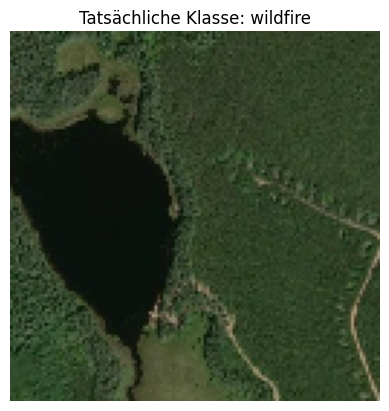

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Vorhergesagte Klasse: wildfire (Wahrscheinlichkeit: 0.69)
✅ Das Modell hat korrekt klassifiziert!


In [41]:
model_path = SAVED_MODEL_DIR / "wildfire_classifier.h5"
model = load_model(model_path)

# Zufälliges Bild aus dem Test-Datensatz testen
test_random_image(model, TEST_DATA_DIR, class_names)

In [34]:
# Teste 5 zufällige Bilder aus dem Test-Datensatz
# for _ in range(5):
#     test_random_image(model, TEST_DATA_DIR, class_names)

### 5. Ausführliche Analyse der Testergebnisse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

2025-01-07 14:20:16.189031: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


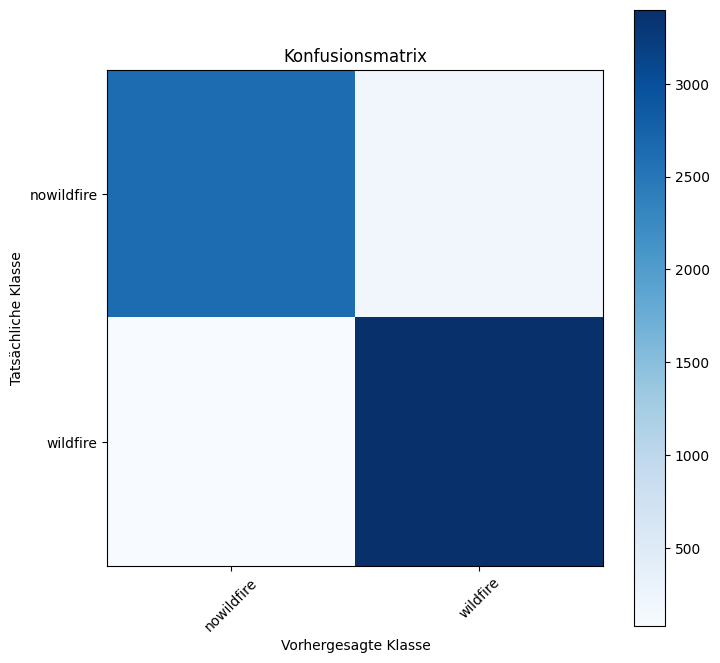

In [42]:
# Vorhersagen für den gesamten Test-Datensatz
y_true = []  # Tatsächliche Labels
y_pred = []  # Vorhergesagte Labels

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Konvertiere in NumPy-Arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Klassifikationsbericht
print("Klassifikationsbericht:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Konfusionsmatrix plotten
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.title("Konfusionsmatrix")
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.show()
